In [23]:
import sys
import os
notebook_path = os.path.abspath("..")  
sys.path.append(notebook_path)
import gymnasium as gym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tarware.warehouse
import pyastar2d
import matplotlib.pyplot as plt
import scipy.stats as stats

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
print(hasattr(pyastar2d, "astar_path")) 

True


In [8]:
# Hyperparameters
learning_rate = 1e-3
gamma = 0.99
hidden_dim = 64
num_episodes = 50

In [9]:
gym.envs.registry.keys()

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'CartPoleJax-v0', 'CartPoleJax-v1', 'PendulumJax-v0', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'Jax-Blackjack-v0', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4', 'GymV21Environment-v0', 'GymV26Environment-v0', 'tarware-tiny-1agvs-1pickers-partialobs-v1', 'tarware-tiny-1agvs-2pickers-partialobs-v1', 'tarware-tiny-1agvs-3p

In [10]:
class Manager(nn.Module):
    def __init__(self, input_dim, num_zones):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_zones)  # Each output is a zone assignment
        )

    def forward(self, obs):
        return self.model(obs)

In [12]:
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.model(x)

class Critic(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)


In [13]:
env = gym.make("tarware-tiny-8agvs-4pickers-partialobs-v1")

zones = env.rack_groups
num_zones = len(zones)

num_agents = len(env.observation_space)
obs_dims = [env.observation_space[i].shape[0] for i in range(num_agents)]
action_dims = [env.action_space[i].n for i in range(num_agents)]

manager = Manager(input_dim=num_agents, num_zones=num_zones).to(device)
manager_opt = optim.Adam(manager.parameters(), lr=1e-3)

actor_nets = [Actor(obs_dims[i] + num_zones, action_dims[i]).to(device) for i in range(num_agents)]
critic_nets = [Critic(obs_dims[i]).to(device) for i in range(num_agents)]

actor_opts = [optim.Adam(actor_nets[i].parameters(), lr=1e-3) for i in range(num_agents)]
critic_opts = [optim.Adam(critic_nets[i].parameters(), lr=1e-3) for i in range(num_agents)]

In [14]:
len(env.observation_space)

12

In [15]:
print(sys.executable)

c:\Users\emrek\.conda\envs\marl_env\python.exe


In [16]:
print(torch.cuda.is_available())     
print(torch.cuda.get_device_name(0)) 

True
NVIDIA GeForce RTX 3070 Laptop GPU


In [17]:
def select_action(actor, obs, zone_id, num_zones):
    # obs_zone = np.concatenate([obs, np.eye(num_zones)[zone_id]]) # one-hot
    # obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
    # obs_tensor = torch.tensor(obs_zone, dtype=torch.float32, device=device).unsqueeze(0)
    obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device)
    zone_onehot = torch.eye(num_zones, device=device)[zone_id]

    obs_zone = torch.cat([obs_tensor, zone_onehot]).unsqueeze(0)
    probs = actor(obs_zone)
    dist = torch.distributions.Categorical(probs)
    action = dist.sample()
    return action.item(), dist.log_prob(action)


In [30]:
num_episodes = 100
gamma = 0.99  # discount factor

episode_rewards = []

def compute_returns(rewards, gamma):
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    return torch.stack(returns)


for ep in range(num_episodes):
    obs = env.reset()
    done = [False] * num_agents
    log_probs = [[] for _ in range(num_agents)]
    values = [[] for _ in range(num_agents)]
    rewards = [[] for _ in range(num_agents)]

    ep_total_reward = 0.0

    # Assign zones using the manager
    # manager_obs = torch.eye(num_agents).sum(dim=0).to(device)
    manager_obs = torch.eye(num_agents).to(device)
    zone_logits = manager(manager_obs)
    zone_dist = torch.distributions.Categorical(logits=zone_logits)
    assigned_zones = zone_dist.sample() # [num_agents]
    # assigned_zones = []
    # for _ in range(num_agents):
    #    zone_logits = manager(manager_obs)
    #    zone_dist = torch.distributions.Categorical(logits=zone_logits)
    #    assigned_zones.append(zone_dist.sample().item())
    # assigned_zones = torch.tensor(assigned_zones)

    while not all(done):
        actions = []
        for i in range(num_agents):
            # action, log_prob = select_action(actor_nets[i], obs[i])
            action, log_prob = select_action(actor_nets[i], obs[i], assigned_zones[i], num_zones)
            value = critic_nets[i](torch.tensor(obs[i], dtype=torch.float32, device=device).unsqueeze(0))

            actions.append(action)
            log_probs[i].append(log_prob)
            values[i].append(value)

        next_obs, reward, terminated, truncated, _ = env.step(actions)
        done = [t or tr for t, tr in zip(terminated, truncated)]

        for i in range(num_agents):
            # rewards[i].append(torch.tensor([reward[i]], dtype=torch.float32))
            r = torch.tensor(reward[i], dtype=torch.float32)
            rewards[i].append(r)
            ep_total_reward += reward[i]

        obs = next_obs

    total_return = 0.0
    # Training step for each agent
    # total_reward = 0.0
    for i in range(num_agents):
        returns = compute_returns(rewards[i], gamma).to(device)
        values_tensor = torch.cat(values[i]).squeeze()
        log_probs_tensor = torch.stack(log_probs[i])

        # advantages = returns - values_tensor.squeeze()
        advantages = returns - values_tensor
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Actor loss
        actor_loss = -(log_probs_tensor * advantages.detach()).mean()

        # Critic loss (MSE)
        critic_loss = advantages.pow(2).mean()

        # Update actor
        actor_opts[i].zero_grad()
        actor_loss.backward()
        actor_opts[i].step()

        # Update critic
        critic_opts[i].zero_grad()
        critic_loss.backward()
        critic_opts[i].step()

        # total_reward += returns.sum().item()
        total_return += returns.sum().item()

    # Train the manager using the total return from all agents
    manager_loss = zone_dist.log_prob(assigned_zones.to(device)).sum() * total_return
    manager_opt.zero_grad()
    manager_loss.backward()
    manager_opt.step()

    episode_rewards.append(ep_total_reward)

print("Training complete.") 

Training complete.


In [29]:
last_50 = episode_rewards[-50:]
mean = np.mean(last_50)
sem = stats.sem(last_50)
ci = stats.t.interval(0.95, len(last_50)-1, loc=mean, scale=sem)
print(f"Pick rate (approx): {mean:.2f} ± {ci[1] - mean:.2f}")

Pick rate (approx): -3.82 ± 0.34


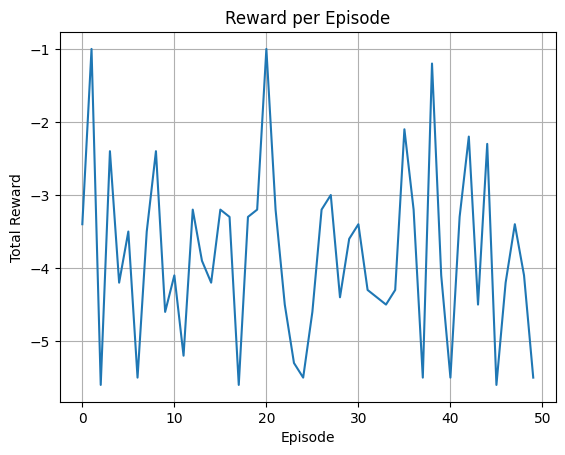

In [27]:
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_rewards = moving_average(episode_rewards, window_size=5)
smoothed = pd.Series(episode_rewards).rolling(5).mean()
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward per Episode")
plt.grid(True)
plt.show()
